

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## Configuration


In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
# pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# set gpu memory
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
%reload_ext autoreload

### Initial Parameters

In [4]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

notebook_name_params = qbz95.utils.get_notebook_name().split('.')[0].split('_')

output_path = os.path.abspath('./output')
data_name = notebook_name_params[0]
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['cats', 'dogs']

train_image_count =  int(notebook_name_params[3])
use_data_augmentation = True if len(notebook_name_params)>=5 and notebook_name_params[4]=='aug' else False

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': use_data_augmentation,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*len(classes)/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': False,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': False,
            'schedule': lr_schedule,            
        }             
    },
    'fine_tune_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        }            
    },    
    'model_params':{
        'mlp':{'dropout':0.3, 'layer_count':1, 'units':128, 'epochs':20},
        'lenet':{'dropout':0.4, 'epochs':20},
        'custom':{'dropout':0.4, 'epochs':20},
        'vgg':{'dropout':0.4, 'epochs':20, 'learning_rate':0.001},
        'resnet':{'dropout':0.4, 'epochs':20},
        'pretrained':{'dropout':0.3, 'epochs':20, 'learning_rate':0.0001}      
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

In [5]:
params.use_data_augmentation

False

## Get Data

### Download Data 

In [6]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [7]:
!ls -l $train_dir
!ls -l $train_dir/cats | wc -l
!ls -l $train_dir/dogs | wc -l
!ls -l $train_dir/cats | head -5

!ls -l $validation_dir/cats | wc -l 
!ls -l $validation_dir/dogs | wc -l

total 84
drwxr-xr-x. 2 root root 24576 Aug 17 05:13 cats
drwxr-xr-x. 2 root root 24576 Aug 17 05:13 dogs
1001
1001
total 22644
-rw-r--r--. 1 root root 12414 Aug 17 06:21 cat.0.jpg
-rw-r--r--. 1 root root 16880 Aug 17 06:21 cat.1.jpg
-rw-r--r--. 1 root root 34315 Aug 17 06:21 cat.10.jpg
-rw-r--r--. 1 root root 28377 Aug 17 06:21 cat.100.jpg
ls: write error: Broken pipe
501
501


In [8]:
def image_to_array(img_file):
    img = load_img(img_file) 
    img = img.resize((160, 160))
    x = img_to_array(img) 
    return x

def images_to_array(image_folder):
    files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    x = np.array([image_to_array(file) for file in files])
    return x 

def load_image_folder(image_folder, classes):
    x = None
    y = None
    for i, class_ in enumerate(classes):
        folder = os.path.join(image_folder, class_) 
        x_ = images_to_array(folder)
        y_ = [i]*len(x_)
        if x is None:
            x = x_
            y = y_
        else:
            x = np.concatenate([x, x_])
            y = np.concatenate([y, y_])
        
    return x, y

train_images, train_labels = load_image_folder(train_dir, params.classes)
print(train_images.shape, train_labels.shape)

test_images, test_labels = load_image_folder(validation_dir, params.classes)
print(test_images.shape, test_labels.shape)

(2000, 160, 160, 3) (2000,)
(1000, 160, 160, 3) (1000,)


In [9]:
len(classes)

2

In [10]:
if params.train_image_count*len(classes)<len(train_images):
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*len(classes), random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

(1000, 160, 160, 3) (1000,)
(1000, 160, 160, 3) (1000,)


In [11]:
Counter(train_labels)

Counter({1: 493, 0: 507})



### Data Explore 

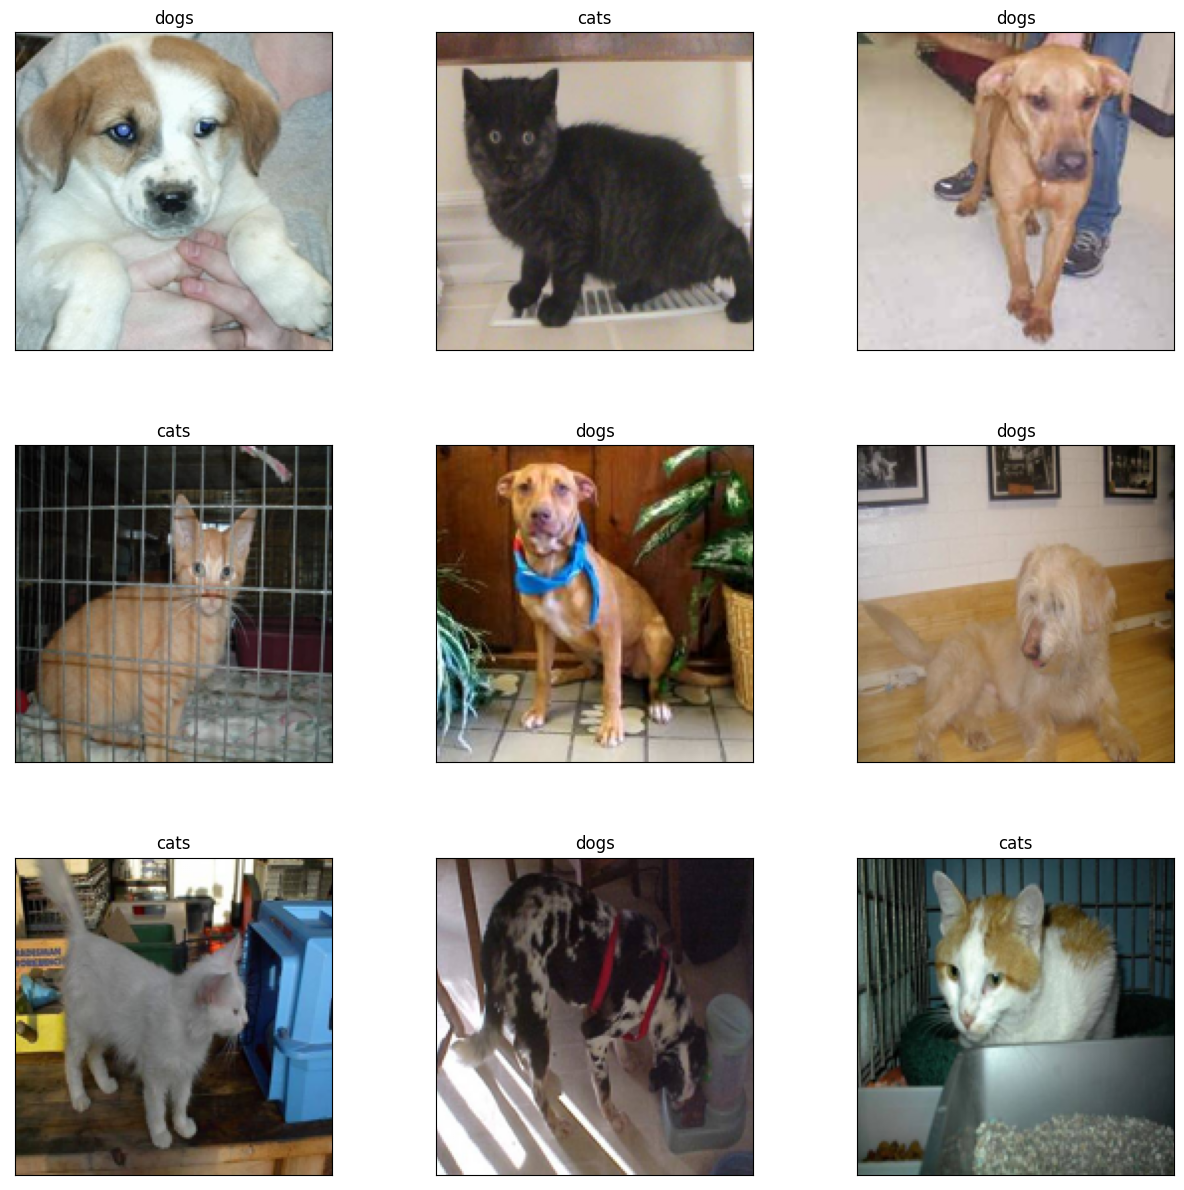

In [12]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=3, figsize=(12, 12))

### Class Distribution

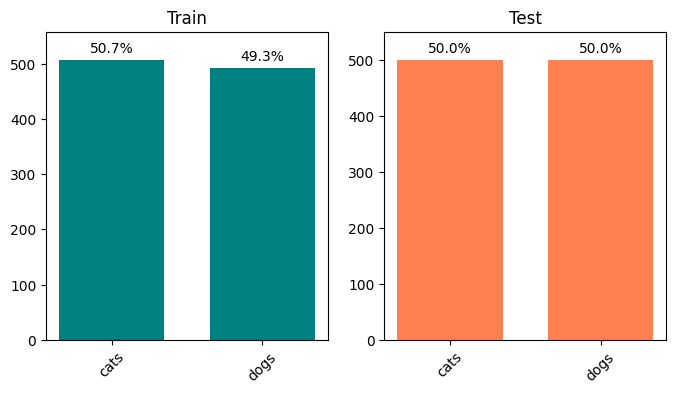

In [13]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## Prepare Data


### Raw Data


In [14]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [15]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [16]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 160, 160, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

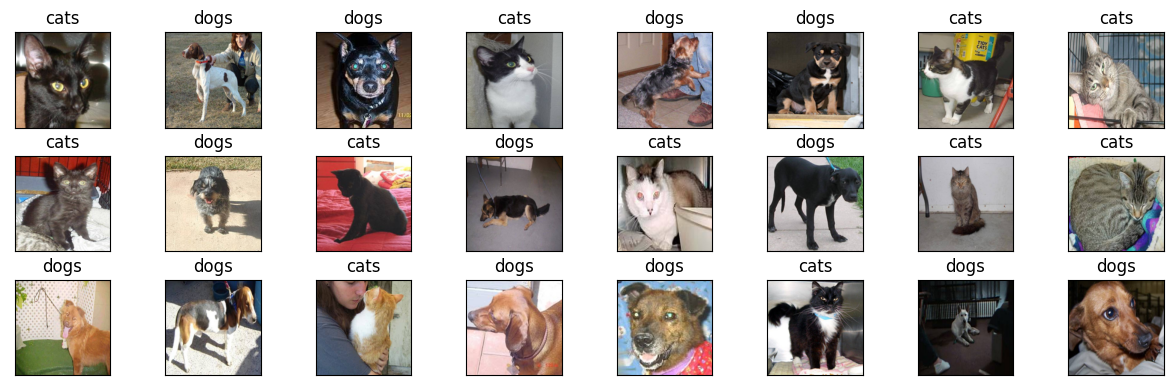

In [17]:
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Data Augmentation

In [18]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

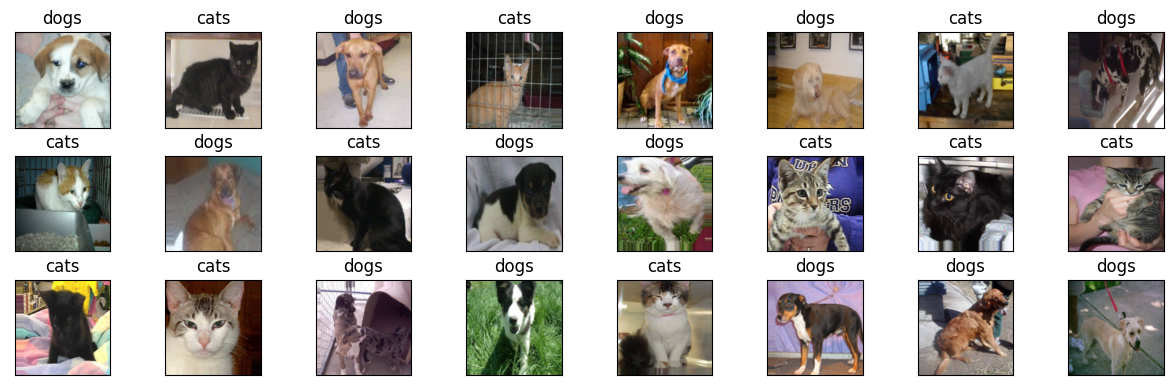

In [19]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

see orgin images

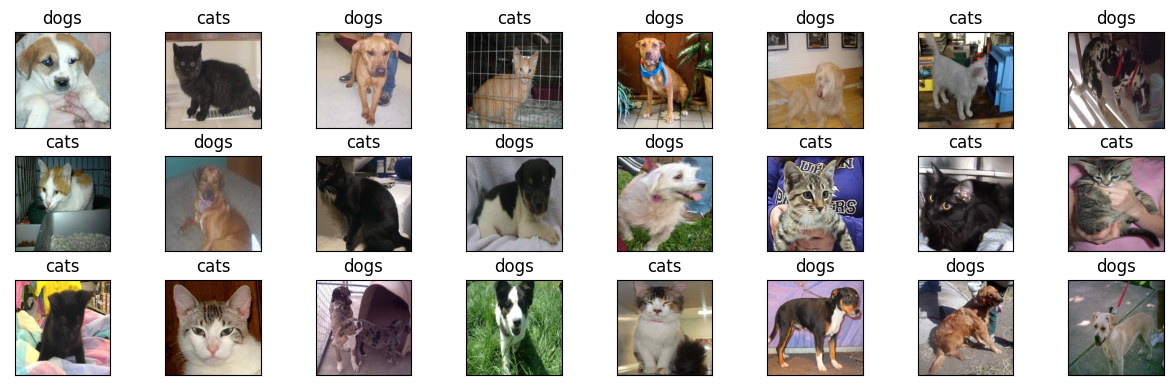

In [20]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

create data augment dataset

In [21]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [22]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


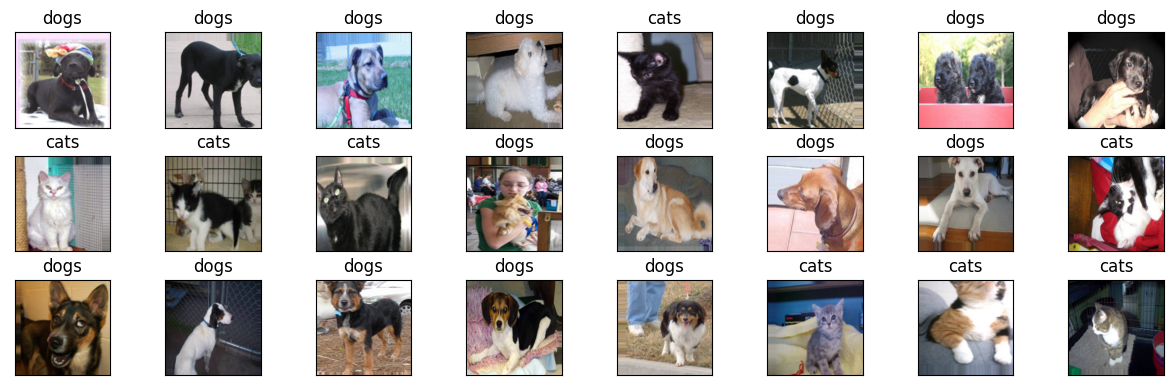

In [23]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  Models



In [24]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### MLP

2022-08-17 06:22:04,762: INFO: model_params.mlp1.dropout=0.3
2022-08-17 06:22:04,763: INFO: model_params.mlp1.layer_count=1
2022-08-17 06:22:04,764: INFO: model_params.mlp1.units=128
2022-08-17 06:22:04,995: INFO: learning_rate=0.001
2022-08-17 06:22:04,996: INFO: model_params.mlp1.clip_value=None
2022-08-17 06:22:05,006: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/mlp1


Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 flatten (Flatten)           (None, 76800)             0         
                                                                 
 dense (Dense)               (None, 128)               9830528   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 9,830,786
Trainable params: 9,830,786
Non-traina

2022-08-17 06:22:05,019: INFO: model_params.mlp1.epochs=20
2022-08-17 06:22:05,020: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/mlp1, monitor=val_accuracy)
2022-08-17 06:22:05,020: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 06:22:05,021: INFO: steps_per_epoch=31
2022-08-17 06:22:05,022: INFO: start training
2022-08-17 06:22:05,022: INFO: use_class_weight=False


Epoch 1/20
30/31 [============================>.] - ETA: 0s - loss: 11.9070 - accuracy: 0.5365INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/mlp1/assets


2022-08-17 06:22:08,005: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/mlp1/assets


31/31 [==============================] - 3s 68ms/step - loss: 11.7576 - accuracy: 0.5393 - val_loss: 15.9147 - val_accuracy: 0.5490
Epoch 2/20
25/31 [=======================>......] - ETA: 0s - loss: 10.5604 - accuracy: 0.6250INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/mlp1/assets


2022-08-17 06:22:09,423: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/mlp1/assets


31/31 [==============================] - 1s 46ms/step - loss: 10.3103 - accuracy: 0.6240 - val_loss: 10.3447 - val_accuracy: 0.5680
Epoch 3/20
31/31 [==============================] - 0s 14ms/step - loss: 4.1854 - accuracy: 0.6552 - val_loss: 8.1275 - val_accuracy: 0.5590
Epoch 4/20
31/31 [==============================] - 0s 15ms/step - loss: 4.6347 - accuracy: 0.7097 - val_loss: 10.5974 - val_accuracy: 0.5650
Epoch 5/20
26/31 [========================>.....] - ETA: 0s - loss: 4.4024 - accuracy: 0.6971INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/mlp1/assets


2022-08-17 06:22:11,718: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/mlp1/assets


31/31 [==============================] - 1s 45ms/step - loss: 3.9747 - accuracy: 0.7056 - val_loss: 7.2357 - val_accuracy: 0.5910
Epoch 6/20
31/31 [==============================] - 0s 15ms/step - loss: 2.1360 - accuracy: 0.7802 - val_loss: 7.7954 - val_accuracy: 0.5460
Epoch 7/20
31/31 [==============================] - 0s 15ms/step - loss: 1.0641 - accuracy: 0.8085 - val_loss: 8.9628 - val_accuracy: 0.5610
Epoch 8/20
31/31 [==============================] - 0s 15ms/step - loss: 1.7841 - accuracy: 0.8135 - val_loss: 11.1354 - val_accuracy: 0.5740
Epoch 9/20
31/31 [==============================] - 0s 15ms/step - loss: 2.0706 - accuracy: 0.7792 - val_loss: 9.5618 - val_accuracy: 0.5780
Epoch 10/20
31/31 [==============================] - 0s 15ms/step - loss: 1.2497 - accuracy: 0.8105 - val_loss: 8.6438 - val_accuracy: 0.5820
Epoch 11/20
31/31 [==============================] - 0s 15ms/step - loss: 1.6805 - accuracy: 0.7984 - val_loss: 9.5494 - val_accuracy: 0.5860
Epoch 12/20
31/31 [==

2022-08-17 06:22:18,606: INFO: finish training [elapsed time: 13.58 seconds]


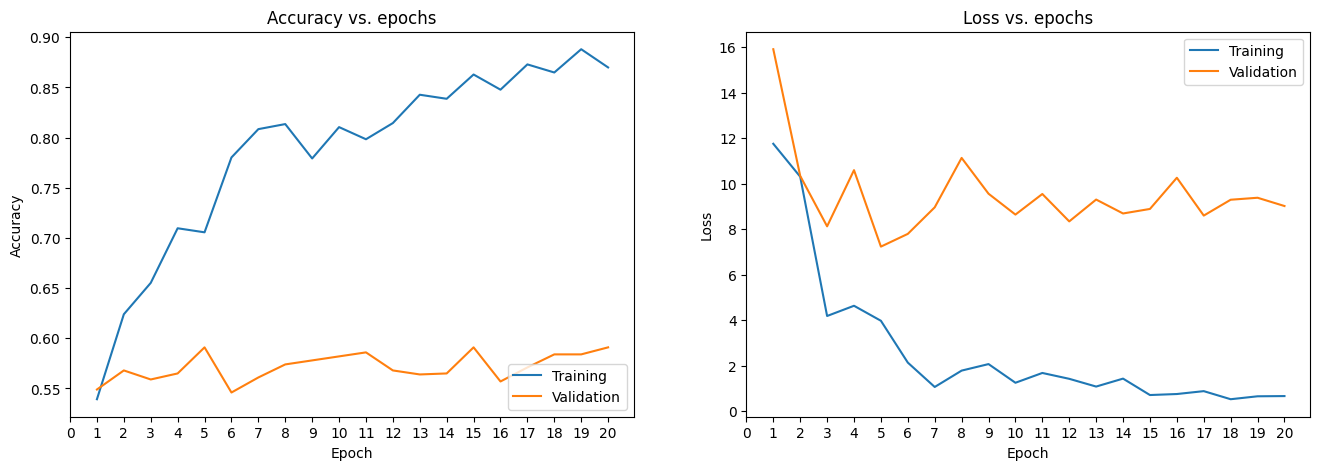

2022-08-17 06:22:19,095: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/mlp1
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 0s 5ms/step


2022-08-17 06:22:24,156: INFO: test loss:7.2357
2022-08-17 06:22:24,157: INFO: test accuracy:0.5910
2022-08-17 06:22:24,158: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/results.json
2022-08-17 06:22:24,160: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/results.json
2022-08-17 06:22:24,160: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator
2022-08-17 06:22:24,162: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
32/32 [==============================] - 0s 5ms/step


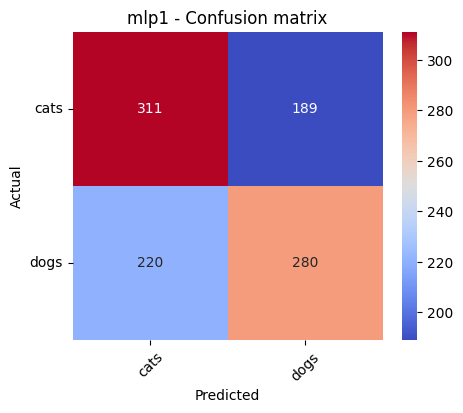

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1       mlp1  catsdogs_0808_cnt_500.ipynb        9830786        13.6   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-17 06:22      1.0128     7.2357           0.811          0.591   

   train_auc  test_auc  
1     0.8976    0.6064

In [25]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 




### LeNet

![image-20201019113632136](images/image-20201019113632136.png)


2022-08-17 06:22:25,509: INFO: model_params.lenet1.dropout=0.4
2022-08-17 06:22:25,609: INFO: learning_rate=0.001
2022-08-17 06:22:25,610: INFO: model_params.lenet1.clip_value=None
2022-08-17 06:22:25,616: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1


Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 160, 160, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 80, 80, 6)         0    

2022-08-17 06:22:25,647: INFO: model_params.lenet1.epochs=20
2022-08-17 06:22:25,648: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1, monitor=val_accuracy)
2022-08-17 06:22:25,648: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 06:22:25,649: INFO: steps_per_epoch=31
2022-08-17 06:22:25,650: INFO: start training
2022-08-17 06:22:25,650: INFO: use_class_weight=False


Epoch 1/20
28/31 [==========================>...] - ETA: 0s - loss: 2.2405 - accuracy: 0.5379

2022-08-17 06:22:30,041: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


2022-08-17 06:22:30,713: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


31/31 [==============================] - 5s 101ms/step - loss: 2.1215 - accuracy: 0.5343 - val_loss: 0.7672 - val_accuracy: 0.5440
Epoch 2/20
31/31 [==============================] - 1s 27ms/step - loss: 0.7522 - accuracy: 0.5272 - val_loss: 1.0979 - val_accuracy: 0.5060
Epoch 3/20
31/31 [==============================] - 1s 26ms/step - loss: 0.7004 - accuracy: 0.5262 - val_loss: 1.4370 - val_accuracy: 0.5260
Epoch 4/20
31/31 [==============================] - 1s 26ms/step - loss: 0.6858 - accuracy: 0.5716 - val_loss: 1.7271 - val_accuracy: 0.5180
Epoch 5/20
29/31 [===========================>..] - ETA: 0s - loss: 0.6691 - accuracy: 0.5593

2022-08-17 06:22:35,302: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


2022-08-17 06:22:35,968: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


31/31 [==============================] - 3s 92ms/step - loss: 0.6666 - accuracy: 0.5595 - val_loss: 1.5825 - val_accuracy: 0.5460
Epoch 6/20
30/31 [============================>.] - ETA: 0s - loss: 0.6688 - accuracy: 0.5396

2022-08-17 06:22:38,281: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


2022-08-17 06:22:38,943: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


31/31 [==============================] - 3s 99ms/step - loss: 0.6665 - accuracy: 0.5413 - val_loss: 1.6828 - val_accuracy: 0.5470
Epoch 7/20
30/31 [============================>.] - ETA: 0s - loss: 0.6574 - accuracy: 0.5583

2022-08-17 06:22:41,099: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


2022-08-17 06:22:41,744: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


31/31 [==============================] - 3s 93ms/step - loss: 0.6568 - accuracy: 0.5595 - val_loss: 2.1292 - val_accuracy: 0.5480
Epoch 8/20
31/31 [==============================] - 1s 27ms/step - loss: 0.6520 - accuracy: 0.5645 - val_loss: 1.8490 - val_accuracy: 0.5350
Epoch 9/20
29/31 [===========================>..] - ETA: 0s - loss: 0.6632 - accuracy: 0.5711

2022-08-17 06:22:44,710: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


2022-08-17 06:22:45,366: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


31/31 [==============================] - 3s 92ms/step - loss: 0.6664 - accuracy: 0.5696 - val_loss: 1.4431 - val_accuracy: 0.5650
Epoch 10/20
31/31 [==============================] - 1s 27ms/step - loss: 0.6599 - accuracy: 0.5877 - val_loss: 1.5264 - val_accuracy: 0.5610
Epoch 11/20
30/31 [============================>.] - ETA: 0s - loss: 0.6325 - accuracy: 0.5948

2022-08-17 06:22:48,526: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


2022-08-17 06:22:49,169: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


31/31 [==============================] - 3s 98ms/step - loss: 0.6308 - accuracy: 0.5968 - val_loss: 1.4658 - val_accuracy: 0.6010
Epoch 12/20
31/31 [==============================] - 1s 26ms/step - loss: 0.6705 - accuracy: 0.5766 - val_loss: 1.6480 - val_accuracy: 0.5610
Epoch 13/20
31/31 [==============================] - 1s 27ms/step - loss: 0.6587 - accuracy: 0.5655 - val_loss: 2.2399 - val_accuracy: 0.5530
Epoch 14/20
30/31 [============================>.] - ETA: 0s - loss: 0.6343 - accuracy: 0.5844

2022-08-17 06:22:52,918: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


2022-08-17 06:22:53,566: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


31/31 [==============================] - 3s 91ms/step - loss: 0.6337 - accuracy: 0.5837 - val_loss: 1.8524 - val_accuracy: 0.6370
Epoch 15/20
31/31 [==============================] - 1s 26ms/step - loss: 0.6323 - accuracy: 0.5514 - val_loss: 1.7779 - val_accuracy: 0.6160
Epoch 16/20
31/31 [==============================] - 1s 27ms/step - loss: 0.6137 - accuracy: 0.5927 - val_loss: 1.5191 - val_accuracy: 0.6250
Epoch 17/20
31/31 [==============================] - 1s 26ms/step - loss: 0.6010 - accuracy: 0.6351 - val_loss: 1.3902 - val_accuracy: 0.6210
Epoch 18/20
31/31 [==============================] - 1s 27ms/step - loss: 0.6466 - accuracy: 0.6341 - val_loss: 0.8999 - val_accuracy: 0.6360
Epoch 19/20
30/31 [============================>.] - ETA: 0s - loss: 0.5659 - accuracy: 0.6479

2022-08-17 06:22:58,995: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


2022-08-17 06:22:59,651: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


31/31 [==============================] - 3s 92ms/step - loss: 0.5642 - accuracy: 0.6502 - val_loss: 1.1068 - val_accuracy: 0.6400
Epoch 20/20
29/31 [===========================>..] - ETA: 0s - loss: 0.5488 - accuracy: 0.6638

2022-08-17 06:23:01,984: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


2022-08-17 06:23:02,637: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1/assets


31/31 [==============================] - 3s 99ms/step - loss: 0.5460 - accuracy: 0.6653 - val_loss: 1.2310 - val_accuracy: 0.6470


2022-08-17 06:23:02,700: INFO: finish training [elapsed time: 37.05 seconds]


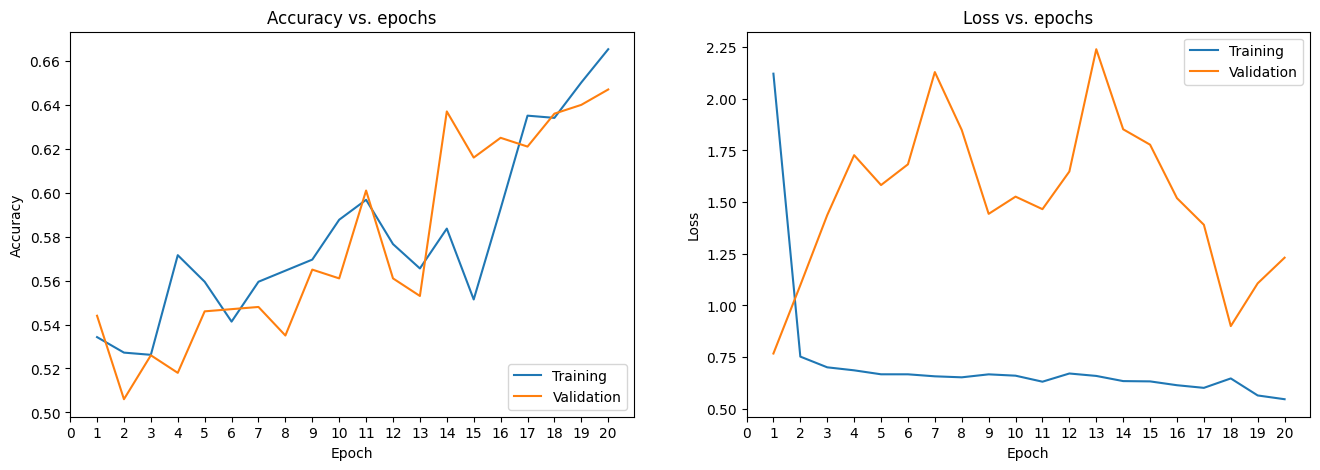

2022-08-17 06:23:03,168: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/lenet1
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 1s 7ms/step


2022-08-17 06:23:08,847: INFO: test loss:1.2310
2022-08-17 06:23:08,848: INFO: test accuracy:0.6470
2022-08-17 06:23:08,849: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/results.json
2022-08-17 06:23:08,851: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/results.json
2022-08-17 06:23:08,852: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator
2022-08-17 06:23:08,853: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator
2022-08-17 06:23:08,853: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/ml

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-17 06:23:09,312: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator


32/32 [==============================] - 1s 5ms/step


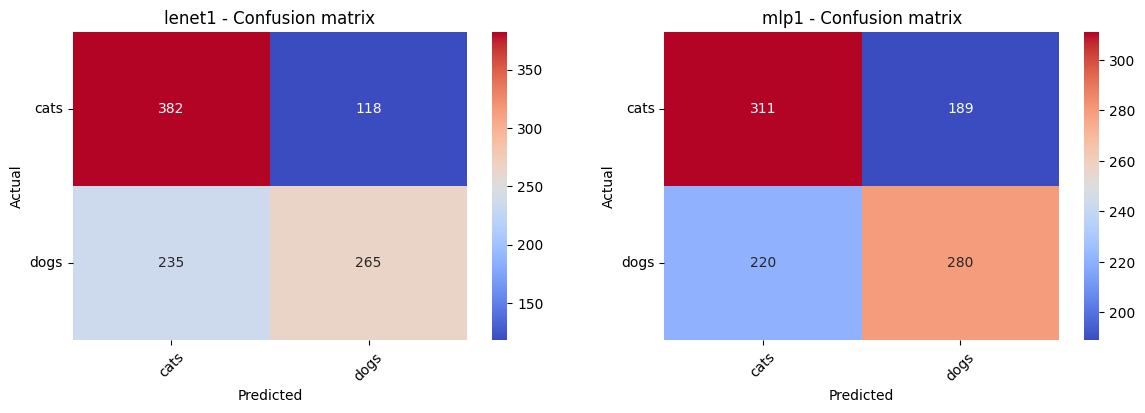

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1     lenet1  catsdogs_0808_cnt_500.ipynb        2785850        37.1   
2       mlp1  catsdogs_0808_cnt_500.ipynb        9830786        13.6   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-17 06:23      0.6200     1.2310           0.737          0.647   
2  2022-08-17 06:22      1.0128     7.2357           0.811          0.591   

   train_auc  test_auc  
1     0.8425    0.6968  
2     0.8976    0.6064

In [26]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Custom 1


2022-08-17 06:23:11,992: INFO: model_params.custom1.dropout=0.4
2022-08-17 06:23:12,124: INFO: learning_rate=0.001
2022-08-17 06:23:12,125: INFO: model_params.custom1.clip_value=None
2022-08-17 06:23:12,132: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1


Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 160, 160, 32)      896       
                                                                 
 batch_normalization_2 (Batc  (None, 160, 160, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 80, 80, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 80, 80, 32)        0   

2022-08-17 06:23:12,176: INFO: model_params.custom1.epochs=20
2022-08-17 06:23:12,177: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1, monitor=val_accuracy)
2022-08-17 06:23:12,177: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 06:23:12,178: INFO: steps_per_epoch=31
2022-08-17 06:23:12,179: INFO: start training
2022-08-17 06:23:12,180: INFO: use_class_weight=False


Epoch 1/20
31/31 [==============================] - ETA: 0s - loss: 1.4891 - accuracy: 0.5383

2022-08-17 06:23:17,051: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1/assets


2022-08-17 06:23:17,756: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1/assets


31/31 [==============================] - 6s 151ms/step - loss: 1.4891 - accuracy: 0.5383 - val_loss: 2.9426 - val_accuracy: 0.4990
Epoch 2/20
31/31 [==============================] - 2s 54ms/step - loss: 0.6854 - accuracy: 0.5675 - val_loss: 3.6005 - val_accuracy: 0.4980
Epoch 3/20
31/31 [==============================] - 2s 54ms/step - loss: 0.6674 - accuracy: 0.5988 - val_loss: 5.0150 - val_accuracy: 0.4990
Epoch 4/20
31/31 [==============================] - 2s 54ms/step - loss: 0.6650 - accuracy: 0.5806 - val_loss: 7.0837 - val_accuracy: 0.4990
Epoch 5/20
30/31 [============================>.] - ETA: 0s - loss: 0.6464 - accuracy: 0.6135

2022-08-17 06:23:25,957: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1/assets


2022-08-17 06:23:26,664: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1/assets


31/31 [==============================] - 4s 128ms/step - loss: 0.6475 - accuracy: 0.6159 - val_loss: 4.0980 - val_accuracy: 0.5090
Epoch 6/20
31/31 [==============================] - 2s 54ms/step - loss: 0.6838 - accuracy: 0.5998 - val_loss: 7.3110 - val_accuracy: 0.4990
Epoch 7/20
31/31 [==============================] - 2s 54ms/step - loss: 0.7034 - accuracy: 0.5524 - val_loss: 3.3379 - val_accuracy: 0.5000
Epoch 8/20
31/31 [==============================] - 2s 54ms/step - loss: 0.6485 - accuracy: 0.6008 - val_loss: 3.6822 - val_accuracy: 0.5000
Epoch 9/20
31/31 [==============================] - 2s 54ms/step - loss: 0.6244 - accuracy: 0.6149 - val_loss: 2.7730 - val_accuracy: 0.5010
Epoch 10/20
31/31 [==============================] - 2s 53ms/step - loss: 0.6187 - accuracy: 0.6190 - val_loss: 2.4688 - val_accuracy: 0.4950
Epoch 11/20
31/31 [==============================] - ETA: 0s - loss: 0.5793 - accuracy: 0.6573

2022-08-17 06:23:38,181: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1/assets


2022-08-17 06:23:38,891: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1/assets


31/31 [==============================] - 4s 127ms/step - loss: 0.5793 - accuracy: 0.6573 - val_loss: 2.3927 - val_accuracy: 0.5110
Epoch 12/20
31/31 [==============================] - ETA: 0s - loss: 0.5573 - accuracy: 0.6845

2022-08-17 06:23:43,241: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1/assets


2022-08-17 06:23:43,939: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1/assets


31/31 [==============================] - 5s 166ms/step - loss: 0.5573 - accuracy: 0.6845 - val_loss: 1.0547 - val_accuracy: 0.5380
Epoch 13/20
31/31 [==============================] - ETA: 0s - loss: 0.5577 - accuracy: 0.6714

2022-08-17 06:23:48,094: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1/assets


2022-08-17 06:23:48,816: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1/assets


31/31 [==============================] - 5s 160ms/step - loss: 0.5577 - accuracy: 0.6714 - val_loss: 1.6343 - val_accuracy: 0.5690
Epoch 14/20
31/31 [==============================] - ETA: 0s - loss: 0.5928 - accuracy: 0.6653

2022-08-17 06:23:51,999: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1/assets


2022-08-17 06:23:52,972: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1/assets


31/31 [==============================] - 4s 137ms/step - loss: 0.5928 - accuracy: 0.6653 - val_loss: 0.9481 - val_accuracy: 0.5880
Epoch 15/20
31/31 [==============================] - 2s 54ms/step - loss: 0.5605 - accuracy: 0.6522 - val_loss: 2.1422 - val_accuracy: 0.5630
Epoch 16/20
31/31 [==============================] - 2s 54ms/step - loss: 0.5201 - accuracy: 0.6855 - val_loss: 1.6808 - val_accuracy: 0.5790
Epoch 17/20
31/31 [==============================] - ETA: 0s - loss: 0.5119 - accuracy: 0.6875

2022-08-17 06:23:59,544: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1/assets


2022-08-17 06:24:00,263: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1/assets


31/31 [==============================] - 4s 128ms/step - loss: 0.5119 - accuracy: 0.6875 - val_loss: 0.9735 - val_accuracy: 0.6140
Epoch 18/20
30/31 [============================>.] - ETA: 0s - loss: 0.4862 - accuracy: 0.7083

2022-08-17 06:24:03,461: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1/assets


2022-08-17 06:24:04,178: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1/assets


31/31 [==============================] - 4s 129ms/step - loss: 0.4824 - accuracy: 0.7127 - val_loss: 0.7458 - val_accuracy: 0.6640
Epoch 19/20
31/31 [==============================] - 2s 54ms/step - loss: 0.4724 - accuracy: 0.7329 - val_loss: 0.9210 - val_accuracy: 0.6400
Epoch 20/20
31/31 [==============================] - 2s 54ms/step - loss: 0.4501 - accuracy: 0.7308 - val_loss: 0.8361 - val_accuracy: 0.6600


2022-08-17 06:24:07,616: INFO: finish training [elapsed time: 55.44 seconds]


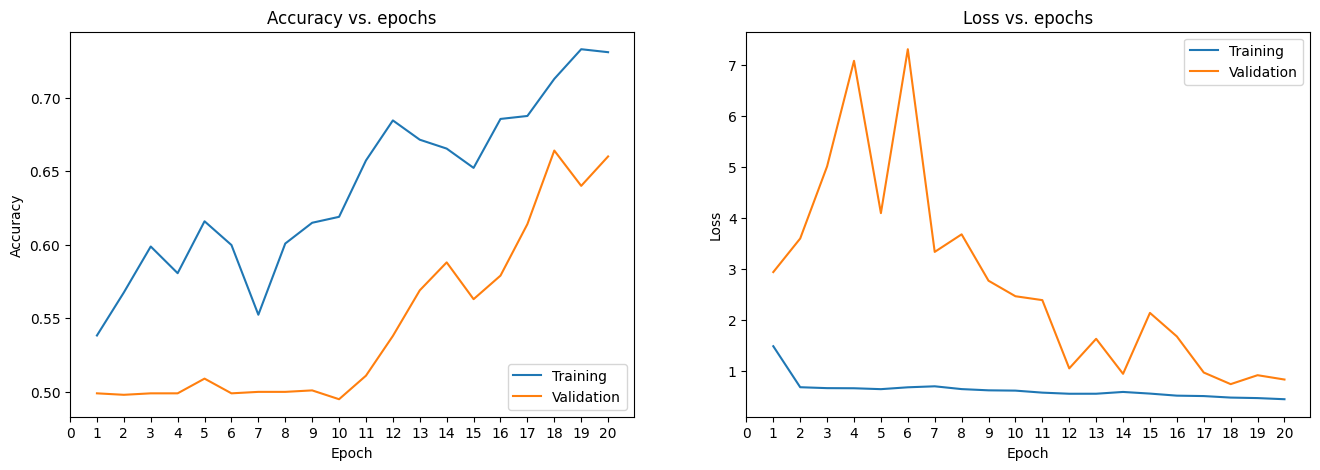

2022-08-17 06:24:08,064: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/custom1
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 1s 12ms/step


2022-08-17 06:24:14,905: INFO: test loss:0.7458
2022-08-17 06:24:14,905: INFO: test accuracy:0.6640
2022-08-17 06:24:14,907: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/results.json
2022-08-17 06:24:14,909: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/results.json
2022-08-17 06:24:14,909: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator
2022-08-17 06:24:14,910: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator
2022-08-17 06:24:14,911: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/le

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-17 06:24:15,838: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator


32/32 [==============================] - 1s 7ms/step


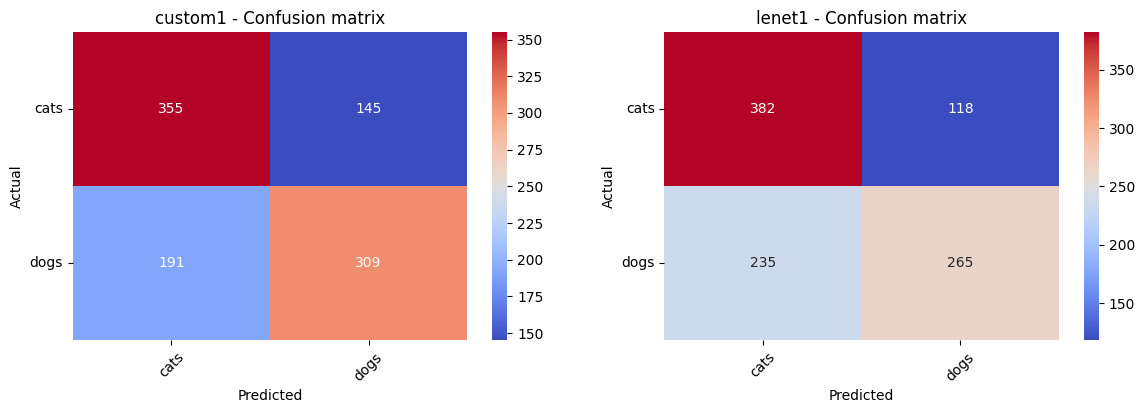

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1    custom1  catsdogs_0808_cnt_500.ipynb        1383938        55.4   
2     lenet1  catsdogs_0808_cnt_500.ipynb        2785850        37.1   
3       mlp1  catsdogs_0808_cnt_500.ipynb        9830786        13.6   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-17 06:24      0.4172     0.7458           0.813          0.664   
2  2022-08-17 06:23      0.6200     1.2310           0.737          0.647   
3  2022-08-17 06:22      1.0128     7.2357           0.811          0.591   

   train_auc  test_auc  
1     0.8973    0.7197  
2     0.8425    0.6968  
3     0.8976    0.6064

In [27]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### VGG

In [28]:
rescale1 = tf.keras.layers.Rescaling(1./255.0)
for data, label in datasets.train_dataset.take(1):
    print(data[0][0][0:5]) 
    print(rescale(data)[0][0][0:5])  

tf.Tensor(
[[13. 15. 14.]
 [12. 14. 13.]
 [15. 17. 16.]
 [18. 20. 19.]
 [16. 18. 17.]], shape=(5, 3), dtype=float32)
tf.Tensor(
[[-0.8980392  -0.88235295 -0.8901961 ]
 [-0.90588236 -0.8901961  -0.8980392 ]
 [-0.88235295 -0.8666667  -0.8745098 ]
 [-0.85882354 -0.84313726 -0.8509804 ]
 [-0.8745098  -0.85882354 -0.8666667 ]], shape=(5, 3), dtype=float32)


In [29]:

helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3, 
                                             preprocess_fun=rescale)
model.summary()


2022-08-17 06:24:19,213: INFO: model_params.vgg8.dropout=0.4
2022-08-17 06:24:19,399: INFO: model_params.vgg8.learning_rate=0.001
2022-08-17 06:24:19,400: INFO: model_params.vgg8.clip_value=None
2022-08-17 06:24:19,406: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 block1_con1 (Conv2D)        (None, 160, 160, 64)      1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 160, 160, 64)     256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 160, 160, 64)      0         
                                                                 
 block1_con2 (Conv2D)        (None, 160, 160, 64)      36928     
                                                              

2022-08-17 06:24:19,542: INFO: model_params.vgg8.epochs=20
2022-08-17 06:24:19,543: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/vgg8, monitor=val_accuracy)
2022-08-17 06:24:19,543: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 06:24:19,544: INFO: steps_per_epoch=31
2022-08-17 06:24:19,544: INFO: start training
2022-08-17 06:24:19,545: INFO: use_class_weight=False


Epoch 1/20
31/31 [==============================] - ETA: 0s - loss: 19.7825 - accuracy: 0.5141

2022-08-17 06:24:32,755: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/vgg8/assets


2022-08-17 06:24:34,186: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/vgg8/assets


31/31 [==============================] - 15s 412ms/step - loss: 19.7825 - accuracy: 0.5141 - val_loss: 3.8365 - val_accuracy: 0.4970
Epoch 2/20
31/31 [==============================] - 8s 252ms/step - loss: 3.0330 - accuracy: 0.5252 - val_loss: 0.7726 - val_accuracy: 0.4950
Epoch 3/20
31/31 [==============================] - ETA: 0s - loss: 0.9281 - accuracy: 0.5212

2022-08-17 06:24:52,122: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/vgg8/assets


2022-08-17 06:24:53,587: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/vgg8/assets


31/31 [==============================] - 12s 382ms/step - loss: 0.9281 - accuracy: 0.5212 - val_loss: 0.7053 - val_accuracy: 0.5020
Epoch 4/20
31/31 [==============================] - 8s 252ms/step - loss: 0.7158 - accuracy: 0.5413 - val_loss: 0.6982 - val_accuracy: 0.4920
Epoch 5/20
31/31 [==============================] - 8s 253ms/step - loss: 0.6788 - accuracy: 0.5675 - val_loss: 0.7004 - val_accuracy: 0.4950
Epoch 6/20
31/31 [==============================] - 8s 252ms/step - loss: 0.6698 - accuracy: 0.5413 - val_loss: 0.7047 - val_accuracy: 0.4950
Epoch 7/20
31/31 [==============================] - 8s 253ms/step - loss: 0.6476 - accuracy: 0.5726 - val_loss: 0.7009 - val_accuracy: 0.4960
Epoch 8/20
31/31 [==============================] - 8s 253ms/step - loss: 0.6414 - accuracy: 0.5877 - val_loss: 0.7135 - val_accuracy: 0.4970
Epoch 9/20
31/31 [==============================] - ETA: 0s - loss: 0.6463 - accuracy: 0.5575

2022-08-17 06:25:42,967: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/vgg8/assets


2022-08-17 06:25:44,475: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/vgg8/assets


31/31 [==============================] - 12s 393ms/step - loss: 0.6463 - accuracy: 0.5575 - val_loss: 0.7043 - val_accuracy: 0.5070
Epoch 10/20
31/31 [==============================] - 8s 251ms/step - loss: 0.6436 - accuracy: 0.5635 - val_loss: 0.7120 - val_accuracy: 0.5070
Epoch 11/20
31/31 [==============================] - 8s 252ms/step - loss: 0.6489 - accuracy: 0.5776 - val_loss: 0.7382 - val_accuracy: 0.5020
Epoch 12/20
31/31 [==============================] - ETA: 0s - loss: 0.6350 - accuracy: 0.5827

2022-08-17 06:26:10,193: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/vgg8/assets


2022-08-17 06:26:11,703: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/vgg8/assets


31/31 [==============================] - 12s 384ms/step - loss: 0.6350 - accuracy: 0.5827 - val_loss: 0.7383 - val_accuracy: 0.5120
Epoch 13/20
31/31 [==============================] - ETA: 0s - loss: 0.6318 - accuracy: 0.5948

2022-08-17 06:26:22,158: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/vgg8/assets


2022-08-17 06:26:23,626: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/vgg8/assets


31/31 [==============================] - 12s 392ms/step - loss: 0.6318 - accuracy: 0.5948 - val_loss: 0.7488 - val_accuracy: 0.5260
Epoch 14/20
31/31 [==============================] - 8s 252ms/step - loss: 0.6257 - accuracy: 0.5968 - val_loss: 0.7849 - val_accuracy: 0.5170
Epoch 15/20
31/31 [==============================] - ETA: 0s - loss: 0.6280 - accuracy: 0.5988

2022-08-17 06:26:41,610: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/vgg8/assets


2022-08-17 06:26:43,315: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/vgg8/assets


31/31 [==============================] - 12s 392ms/step - loss: 0.6280 - accuracy: 0.5988 - val_loss: 0.7755 - val_accuracy: 0.5420
Epoch 16/20
31/31 [==============================] - 8s 253ms/step - loss: 0.6159 - accuracy: 0.6139 - val_loss: 0.7710 - val_accuracy: 0.5240
Epoch 17/20
31/31 [==============================] - 11s 354ms/step - loss: 0.6281 - accuracy: 0.5938 - val_loss: 0.7982 - val_accuracy: 0.5230
Epoch 18/20
31/31 [==============================] - 8s 272ms/step - loss: 0.6213 - accuracy: 0.6139 - val_loss: 0.8145 - val_accuracy: 0.5380
Epoch 19/20
31/31 [==============================] - 6s 204ms/step - loss: 0.6279 - accuracy: 0.5968 - val_loss: 0.7903 - val_accuracy: 0.4940
Epoch 20/20
31/31 [==============================] - 6s 205ms/step - loss: 0.6160 - accuracy: 0.6028 - val_loss: 0.8350 - val_accuracy: 0.5000


2022-08-17 06:27:23,063: INFO: finish training [elapsed time: 183.52 seconds]


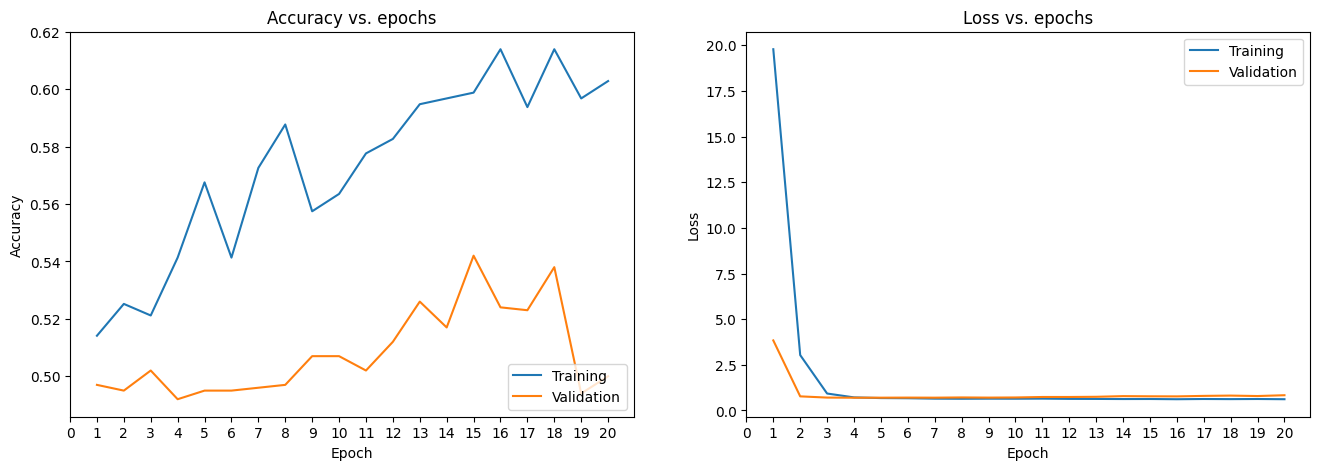

2022-08-17 06:27:23,518: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/vgg8
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 2s 44ms/step


2022-08-17 06:27:34,669: INFO: test loss:0.7755
2022-08-17 06:27:34,670: INFO: test accuracy:0.5420
2022-08-17 06:27:34,672: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/results.json
2022-08-17 06:27:34,674: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/results.json
2022-08-17 06:27:34,675: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator
2022-08-17 06:27:34,676: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator
2022-08-17 06:27:34,676: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/cu

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-17 06:27:35,655: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator


32/32 [==============================] - 1s 10ms/step


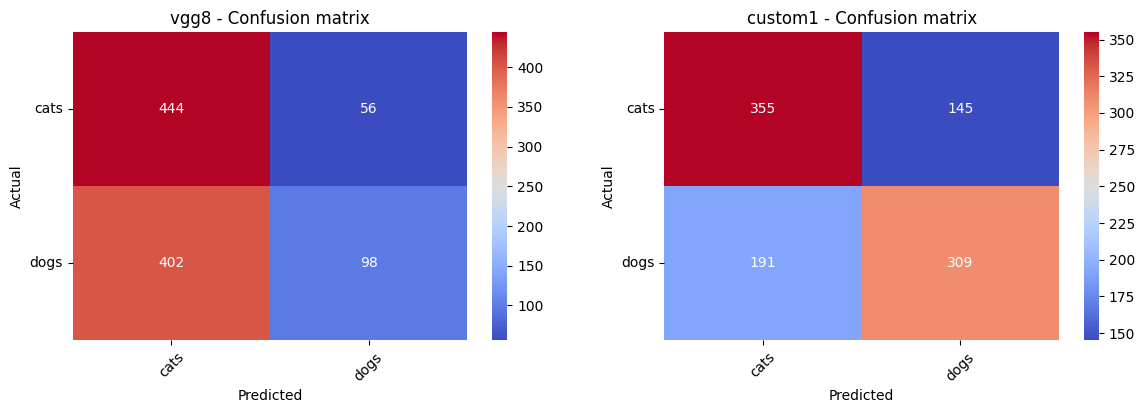

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1    custom1  catsdogs_0808_cnt_500.ipynb        1383938        55.4   
2     lenet1  catsdogs_0808_cnt_500.ipynb        2785850        37.1   
3       mlp1  catsdogs_0808_cnt_500.ipynb        9830786        13.6   
4       vgg8  catsdogs_0808_cnt_500.ipynb       14254786       183.5   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-17 06:24      0.4172     0.7458           0.813          0.664   
2  2022-08-17 06:23      0.6200     1.2310           0.737          0.647   
3  2022-08-17 06:22      1.0128     7.2357           0.811          0.591   
4  2022-08-17 06:27      0.6669     0.7755           0.565          0.542   

   train_auc  test_auc  
1     0.8973    0.7197  
2     0.8425    0.6968  
3     0.8976    0.6064  
4     0.5619    0.4879

In [30]:
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Resnet

see https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

2022-08-17 06:27:40,032: INFO: learning_rate=0.001
2022-08-17 06:27:40,032: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-17 06:27:40,040: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 160, 160, 16  448         ['rescaling[4][0]']              
                                )                                                                 
                                                                                       

 ormalization)                                                                                    
                                                                                                  
 activation_7 (Activation)      (None, 80, 80, 32)   0           ['batch_normalization_12[0][0]'] 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 80, 80, 32)   9248        ['activation_7[0][0]']           
                                                                                                  
 conv2d_14 (Conv2D)             (None, 80, 80, 32)   544         ['activation_6[0][0]']           
                                                                                                  
 batch_normalization_13 (BatchN  (None, 80, 80, 32)  128         ['conv2d_13[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 activation_16 (Activation)     (None, 40, 40, 64)   0           ['add_7[0][0]']                  
                                                                                                  
 conv2d_24 (Conv2D)             (None, 40, 40, 64)   36928       ['activation_16[0][0]']          
                                                                                                  
 batch_normalization_22 (BatchN  (None, 40, 40, 64)  256         ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 40, 40, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_25

2022-08-17 06:27:40,175: INFO: model_params.resnet_v1_20.epochs=20
2022-08-17 06:27:40,175: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20, monitor=val_accuracy)
2022-08-17 06:27:40,176: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 06:27:40,177: INFO: steps_per_epoch=31
2022-08-17 06:27:40,177: INFO: start training
2022-08-17 06:27:40,178: INFO: use_class_weight=False


Epoch 1/20
31/31 [==============================] - ETA: 0s - loss: 1.2855 - accuracy: 0.5786

2022-08-17 06:28:01,924: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


2022-08-17 06:28:04,928: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


31/31 [==============================] - 25s 706ms/step - loss: 1.2855 - accuracy: 0.5786 - val_loss: 7.4084 - val_accuracy: 0.5050
Epoch 2/20
31/31 [==============================] - ETA: 0s - loss: 0.7865 - accuracy: 0.6673

2022-08-17 06:28:23,130: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


2022-08-17 06:28:26,083: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


31/31 [==============================] - 21s 695ms/step - loss: 0.7865 - accuracy: 0.6673 - val_loss: 1.1086 - val_accuracy: 0.5560
Epoch 3/20
31/31 [==============================] - ETA: 0s - loss: 0.6515 - accuracy: 0.7500

2022-08-17 06:28:44,303: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


2022-08-17 06:28:47,232: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


31/31 [==============================] - 21s 696ms/step - loss: 0.6515 - accuracy: 0.7500 - val_loss: 0.8974 - val_accuracy: 0.6040
Epoch 4/20
31/31 [==============================] - ETA: 0s - loss: 0.5364 - accuracy: 0.8317

2022-08-17 06:29:05,775: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


2022-08-17 06:29:08,690: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


31/31 [==============================] - 21s 705ms/step - loss: 0.5364 - accuracy: 0.8317 - val_loss: 0.9535 - val_accuracy: 0.6110
Epoch 5/20
31/31 [==============================] - ETA: 0s - loss: 0.4884 - accuracy: 0.8609

2022-08-17 06:29:27,356: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


2022-08-17 06:29:30,657: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


31/31 [==============================] - 22s 722ms/step - loss: 0.4884 - accuracy: 0.8609 - val_loss: 0.8550 - val_accuracy: 0.6470
Epoch 6/20
31/31 [==============================] - 9s 301ms/step - loss: 0.4187 - accuracy: 0.8901 - val_loss: 0.9983 - val_accuracy: 0.6200
Epoch 7/20
31/31 [==============================] - 5s 172ms/step - loss: 0.3964 - accuracy: 0.9083 - val_loss: 1.0113 - val_accuracy: 0.6180
Epoch 8/20
31/31 [==============================] - 5s 171ms/step - loss: 0.4980 - accuracy: 0.8498 - val_loss: 1.1445 - val_accuracy: 0.6340
Epoch 9/20
31/31 [==============================] - ETA: 0s - loss: 0.4350 - accuracy: 0.8740

2022-08-17 06:30:02,335: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


2022-08-17 06:30:05,652: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


31/31 [==============================] - 15s 498ms/step - loss: 0.4350 - accuracy: 0.8740 - val_loss: 1.1190 - val_accuracy: 0.6640
Epoch 10/20
31/31 [==============================] - 5s 171ms/step - loss: 0.3016 - accuracy: 0.9506 - val_loss: 1.8222 - val_accuracy: 0.5880
Epoch 11/20
31/31 [==============================] - 5s 172ms/step - loss: 0.3568 - accuracy: 0.9173 - val_loss: 1.5945 - val_accuracy: 0.6320
Epoch 12/20
31/31 [==============================] - 5s 172ms/step - loss: 0.4756 - accuracy: 0.8619 - val_loss: 1.5913 - val_accuracy: 0.6600
Epoch 13/20
31/31 [==============================] - 5s 172ms/step - loss: 0.5489 - accuracy: 0.8357 - val_loss: 3.2207 - val_accuracy: 0.5750
Epoch 14/20
31/31 [==============================] - 5s 172ms/step - loss: 0.4610 - accuracy: 0.8841 - val_loss: 4.3179 - val_accuracy: 0.5730
Epoch 15/20
31/31 [==============================] - ETA: 0s - loss: 0.2723 - accuracy: 0.9637

2022-08-17 06:30:44,247: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


2022-08-17 06:30:47,098: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


31/31 [==============================] - 15s 495ms/step - loss: 0.2723 - accuracy: 0.9637 - val_loss: 1.1172 - val_accuracy: 0.6850
Epoch 16/20
31/31 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.9980

2022-08-17 06:30:59,206: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


2022-08-17 06:31:02,078: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


31/31 [==============================] - 15s 494ms/step - loss: 0.1871 - accuracy: 0.9980 - val_loss: 0.9800 - val_accuracy: 0.7090
Epoch 17/20
31/31 [==============================] - 5s 171ms/step - loss: 0.1684 - accuracy: 1.0000 - val_loss: 0.9779 - val_accuracy: 0.7090
Epoch 18/20
31/31 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 1.0000

2022-08-17 06:31:19,467: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


2022-08-17 06:31:22,294: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


31/31 [==============================] - 15s 493ms/step - loss: 0.1630 - accuracy: 1.0000 - val_loss: 0.9857 - val_accuracy: 0.7120
Epoch 19/20
31/31 [==============================] - 5s 171ms/step - loss: 0.1607 - accuracy: 1.0000 - val_loss: 0.9860 - val_accuracy: 0.7090
Epoch 20/20
31/31 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 1.0000

2022-08-17 06:31:39,734: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


2022-08-17 06:31:42,530: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20/assets


31/31 [==============================] - 15s 494ms/step - loss: 0.1595 - accuracy: 1.0000 - val_loss: 0.9884 - val_accuracy: 0.7140


2022-08-17 06:31:42,804: INFO: finish training [elapsed time: 242.63 seconds]


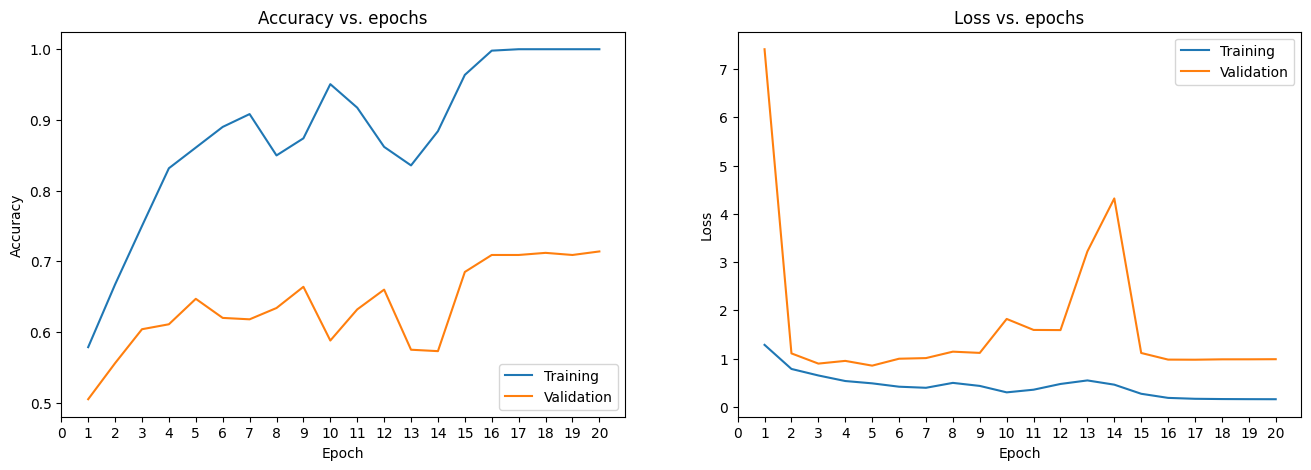

2022-08-17 06:31:43,220: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/resnet_v1_20
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 1s 34ms/step


2022-08-17 06:31:56,331: INFO: test loss:0.9884
2022-08-17 06:31:56,332: INFO: test accuracy:0.7140
2022-08-17 06:31:56,337: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/results.json
2022-08-17 06:31:56,340: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/results.json
2022-08-17 06:31:56,341: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator
2022-08-17 06:31:56,343: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator
2022-08-17 06:31:56,344: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/cu

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-17 06:31:57,285: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator


32/32 [==============================] - 1s 9ms/step


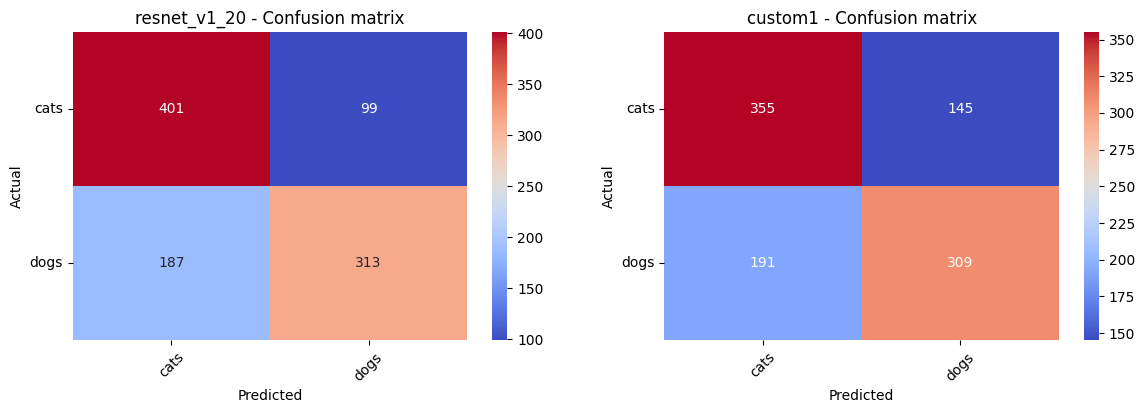

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1  resnet_v1_20  catsdogs_0808_cnt_500.ipynb         275618       242.6   
2       custom1  catsdogs_0808_cnt_500.ipynb        1383938        55.4   
3        lenet1  catsdogs_0808_cnt_500.ipynb        2785850        37.1   
4          mlp1  catsdogs_0808_cnt_500.ipynb        9830786        13.6   
5          vgg8  catsdogs_0808_cnt_500.ipynb       14254786       183.5   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-17 06:31      0.1704     0.9884           0.999          0.714   
2  2022-08-17 06:24      0.4172     0.7458           0.813          0.664   
3  2022-08-17 06:23      0.6200     1.2310           0.737          0.647   
4  2022-08-17 06:22      1.0128     7.2357           0.811          0.591   
5  2022-08-17 06:27      0.6669     0.7755           0.565          0.542   

   train_auc  test_auc  
1     1.0000    0.7936  
2     0.8973    0.7197  
3     0.8425    0.6968  
4     0.8976    0.6064  
5     0.5619    0.4879

In [31]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Pretrained Model + Fune-Tune

In [32]:
input_shape = [160, 160, 3]

def resize(shape):
    def resize_(x):
        return tf.image.resize(x, shape)
    return resize_

In [33]:
preprocess_fun =  [rescale]

(32, 160, 160, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


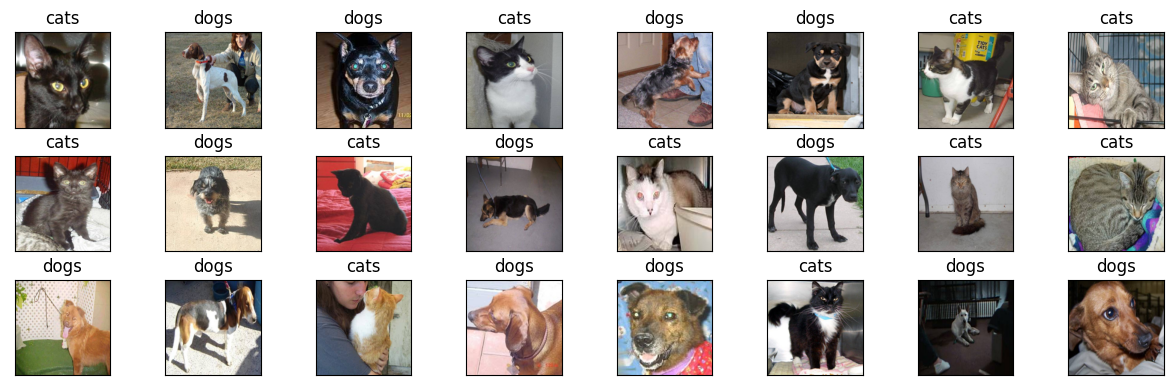

In [34]:
sample_images1 = resize(input_shape[:-1])(sample_images)
print(sample_images1.shape, type(sample_images1)) 
qtf.utils.show_images(sample_images1.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

#### MobileNet V2

In [35]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [36]:
def pretrained_model(helper, base_model, dropout=None, name='pretrained_model', last_activation=None, preprocess_fun=None):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    input_shape = qbz95.tf.classification.get_input_shape(helper.datasets.train_dataset)
    input = layers.Input(shape=input_shape)
    x = qbz95.tf.classification.image_models.process_funs(input, preprocess_fun)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = helper.get_dense_layer(len(helper.params.classes), activation=last_activation)(x)

    model = Model(inputs=input, outputs=x, name=name)
    helper.compile(model)
    return model

def fine_tuning(helper, model, base_model, fine_tune_at, learning_rate=0.00001):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=helper.params.metrics)
    return model 

In [37]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = pretrained_model(helper, base_model, dropout=0.2, name='pretrained-MobileNetV2', preprocess_fun=preprocess_fun)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')
model.summary()

loss0, accuracy0 = model.evaluate(datasets.test_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2022-08-17 06:32:04,338: INFO: model_params.pretrained-MobileNetV2.learning_rate=0.0001
2022-08-17 06:32:04,339: INFO: model_params.pretrained-MobileNetV2.clip_value=None
2022-08-17 06:32:04,347: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2


len(model.trainable_variables)=2
Model: "pretrained-MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_10 (Dropout)        (None, 1280)              0         
                                                                 
 dense_10 (

2022-08-17 06:32:06,929: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-17 06:32:06,930: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 06:32:06,931: INFO: steps_per_epoch=31
2022-08-17 06:32:06,932: INFO: start training
2022-08-17 06:32:06,932: INFO: use_class_weight=False


Epoch 1/10
30/31 [============================>.] - ETA: 0s - loss: 0.7779 - accuracy: 0.5479

2022-08-17 06:32:26,545: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


2022-08-17 06:32:30,940: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


31/31 [==============================] - 25s 725ms/step - loss: 0.7703 - accuracy: 0.5524 - val_loss: 0.5839 - val_accuracy: 0.7070
Epoch 2/10
31/31 [==============================] - ETA: 0s - loss: 0.5157 - accuracy: 0.7480

2022-08-17 06:32:48,929: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


2022-08-17 06:32:53,303: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


31/31 [==============================] - 22s 744ms/step - loss: 0.5157 - accuracy: 0.7480 - val_loss: 0.4075 - val_accuracy: 0.8330
Epoch 3/10
31/31 [==============================] - ETA: 0s - loss: 0.3749 - accuracy: 0.8438

2022-08-17 06:33:11,356: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


2022-08-17 06:33:15,781: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


31/31 [==============================] - 22s 748ms/step - loss: 0.3749 - accuracy: 0.8438 - val_loss: 0.3076 - val_accuracy: 0.8970
Epoch 4/10
31/31 [==============================] - ETA: 0s - loss: 0.2935 - accuracy: 0.9032

2022-08-17 06:33:33,887: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


2022-08-17 06:33:38,302: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


31/31 [==============================] - 22s 749ms/step - loss: 0.2935 - accuracy: 0.9032 - val_loss: 0.2460 - val_accuracy: 0.9360
Epoch 5/10
31/31 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.9194

2022-08-17 06:33:56,390: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


2022-08-17 06:34:00,782: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


31/31 [==============================] - 22s 748ms/step - loss: 0.2455 - accuracy: 0.9194 - val_loss: 0.2057 - val_accuracy: 0.9470
Epoch 6/10
31/31 [==============================] - ETA: 0s - loss: 0.2057 - accuracy: 0.9365

2022-08-17 06:34:18,880: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


2022-08-17 06:34:23,284: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


31/31 [==============================] - 22s 748ms/step - loss: 0.2057 - accuracy: 0.9365 - val_loss: 0.1784 - val_accuracy: 0.9520
Epoch 7/10
31/31 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9435

2022-08-17 06:34:41,262: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


2022-08-17 06:34:45,624: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


31/31 [==============================] - 22s 743ms/step - loss: 0.1819 - accuracy: 0.9435 - val_loss: 0.1584 - val_accuracy: 0.9610
Epoch 8/10
31/31 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.9506

2022-08-17 06:35:03,485: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


2022-08-17 06:35:08,286: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


31/31 [==============================] - 23s 754ms/step - loss: 0.1731 - accuracy: 0.9506 - val_loss: 0.1437 - val_accuracy: 0.9630
Epoch 9/10
31/31 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.9567

2022-08-17 06:35:25,722: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


2022-08-17 06:35:30,474: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


31/31 [==============================] - 22s 739ms/step - loss: 0.1479 - accuracy: 0.9567 - val_loss: 0.1321 - val_accuracy: 0.9660
Epoch 10/10
31/31 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9536

2022-08-17 06:35:48,177: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


2022-08-17 06:35:53,009: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


31/31 [==============================] - 23s 751ms/step - loss: 0.1441 - accuracy: 0.9536 - val_loss: 0.1224 - val_accuracy: 0.9690


2022-08-17 06:35:53,817: INFO: finish training [elapsed time: 226.89 seconds]


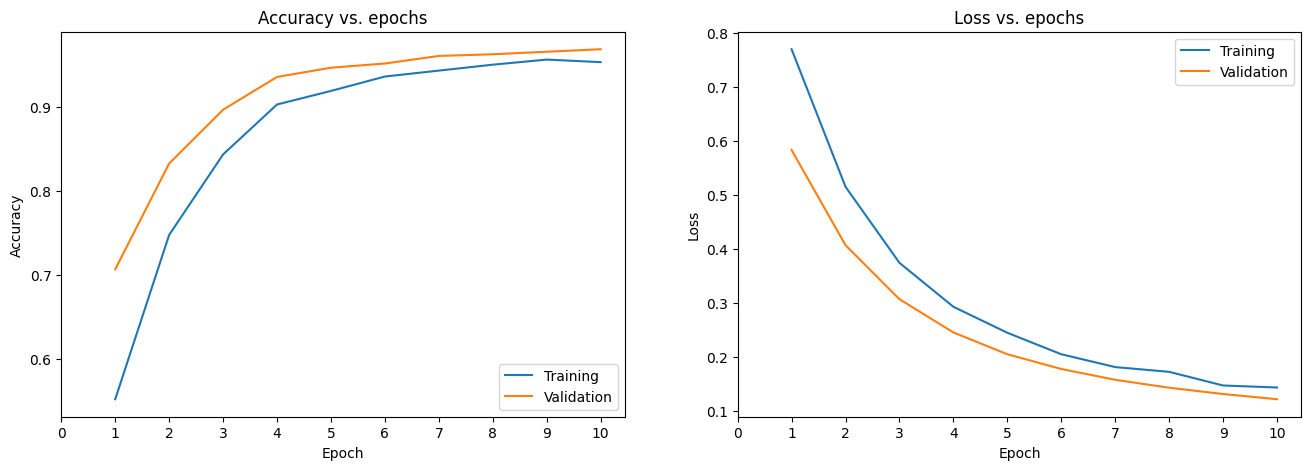

In [38]:
history = helper.train(model, epochs=10)

In [39]:
model = fine_tuning(helper, model, base_model, fine_tune_at=100, learning_rate=0.00001)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')

len(model.trainable_variables)=56


2022-08-17 06:35:54,299: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-17 06:35:54,300: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-17 06:35:54,301: INFO: steps_per_epoch=31
2022-08-17 06:35:54,302: INFO: start training
2022-08-17 06:35:54,302: INFO: use_class_weight=False


Epoch 1/10
31/31 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.9617

2022-08-17 06:36:17,537: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


2022-08-17 06:36:22,655: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2/assets


31/31 [==============================] - 29s 809ms/step - loss: 0.0943 - accuracy: 0.9617 - val_loss: 0.0521 - val_accuracy: 0.9860
Epoch 2/10
31/31 [==============================] - 2s 59ms/step - loss: 0.0331 - accuracy: 0.9909 - val_loss: 0.0414 - val_accuracy: 0.9840
Epoch 3/10
31/31 [==============================] - 2s 59ms/step - loss: 0.0226 - accuracy: 0.9919 - val_loss: 0.0411 - val_accuracy: 0.9820
Epoch 4/10
31/31 [==============================] - 2s 59ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.0391 - val_accuracy: 0.9850
Epoch 5/10
31/31 [==============================] - 2s 59ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0401 - val_accuracy: 0.9860
Epoch 6/10
31/31 [==============================] - 2s 59ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0391 - val_accuracy: 0.9860
Epoch 7/10
31/31 [==============================] - 2s 59ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0416 - val_accuracy: 0.9840
Epoch 8/10
31/31 [====

2022-08-17 06:36:39,799: INFO: finish training [elapsed time: 45.50 seconds]


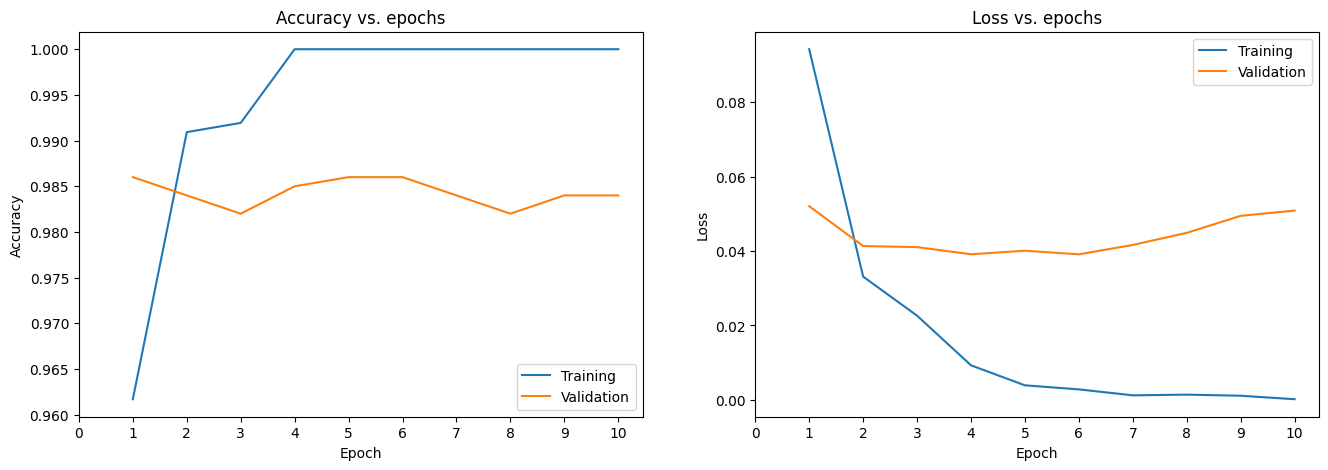

2022-08-17 06:36:40,149: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2
----------------------------------------evaluate----------------------------------------
32/32 [==============================] - 1s 23ms/step


2022-08-17 06:36:58,692: INFO: test loss:0.0521
2022-08-17 06:36:58,693: INFO: test accuracy:0.9860
2022-08-17 06:36:58,696: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/results.json
2022-08-17 06:36:58,698: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/results.json
2022-08-17 06:36:58,698: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator
2022-08-17 06:36:58,699: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator
2022-08-17 06:36:58,700: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/re

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-17 06:37:02,941: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator


32/32 [==============================] - 2s 34ms/step


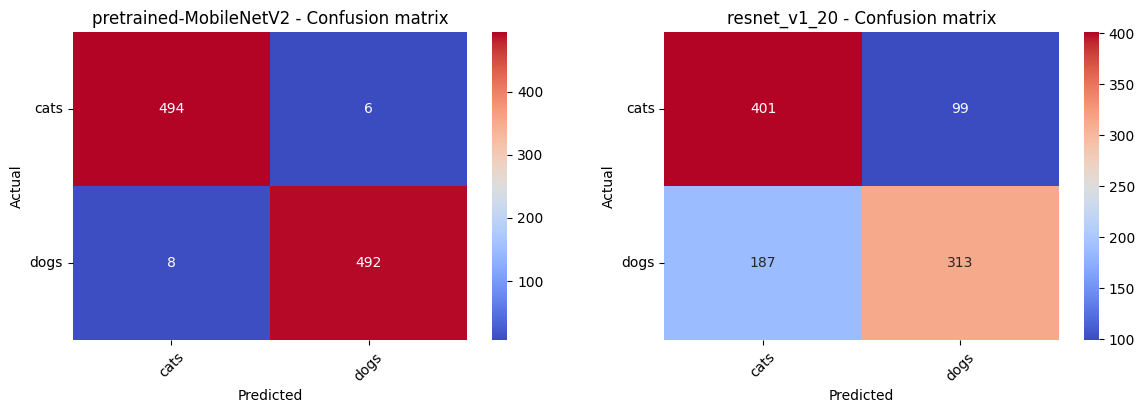

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  \
1  pretrained-MobileNetV2  catsdogs_0808_cnt_500.ipynb        1864002   
2            resnet_v1_20  catsdogs_0808_cnt_500.ipynb         275618   
3                 custom1  catsdogs_0808_cnt_500.ipynb        1383938   
4                  lenet1  catsdogs_0808_cnt_500.ipynb        2785850   
5                    mlp1  catsdogs_0808_cnt_500.ipynb        9830786   
6                    vgg8  catsdogs_0808_cnt_500.ipynb       14254786   

   train_time       create_time  train_loss  test_loss  train_accuracy  \
1        45.5  2022-08-17 06:36      0.0328     0.0521           0.992   
2       242.6  2022-08-17 06:31      0.1704     0.9884           0.999   
3        55.4  2022-08-17 06:24      0.4172     0.7458           0.813   
4        37.1  2022-08-17 06:23      0.6200     1.2310           0.737   
5        13.6  2022-08-17 06:22      1.0128     7.2357           0.811   
6       183.5  2022-08-17 06:27      0.6669     0.7755           0.565   

   test_accuracy  train_auc  test_auc  
1          0.986     0.9999    0.9990  
2          0.714     1.0000    0.7936  
3          0.664     0.8973    0.7197  
4          0.647     0.8425    0.6968  
5          0.591     0.8976    0.6064  
6          0.542     0.5619    0.4879

In [40]:
history = helper.train(model, epochs=10)
helper.model_summary(model, history, show_sample_analysis=False) 

## Evaluation

### Best Model

In [41]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2022-08-17 06:37:07,270: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs
2022-08-17 06:37:07,272: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/results.json
2022-08-17 06:37:07,273: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/results.json


model_name                  program_name  weight_number  \
1   pretrained-MobileNetV2   catsdogs_0808_cnt_500.ipynb        1864002   
2   pretrained-MobileNetV2  catsdogs_0808_cnt_1000.ipynb        1864002   
3             resnet_v1_20  catsdogs_0808_cnt_1000.ipynb         275618   
4             resnet_v1_20   catsdogs_0808_cnt_500.ipynb         275618   
5                  custom1  catsdogs_0808_cnt_1000.ipynb        1383938   
6                  custom1   catsdogs_0808_cnt_500.ipynb        1383938   
7                   lenet1   catsdogs_0808_cnt_500.ipynb        2785850   
8                     mlp1  catsdogs_0808_cnt_1000.ipynb        9830786   
9                     mlp1   catsdogs_0808_cnt_500.ipynb        9830786   
10                    vgg8  catsdogs_0808_cnt_1000.ipynb       14254786   

    train_time       create_time  train_loss  test_loss  train_accuracy  \
1         45.5  2022-08-17 06:36      0.0328     0.0521          0.9920   
2         68.1  2022-08-17 06:20      0.0235     0.0428          0.9935   
3        314.5  2022-08-17 06:14      0.1710     0.8164          0.9980   
4        242.6  2022-08-17 06:31      0.1704     0.9884          0.9990   
5         98.1  2022-08-17 06:03      0.4033     0.6511          0.8155   
6         55.4  2022-08-17 06:24      0.4172     0.7458          0.8130   
7         37.1  2022-08-17 06:23      0.6200     1.2310          0.7370   
8         20.6  2022-08-17 06:00      0.2677     3.3658          0.9190   
9         13.6  2022-08-17 06:22      1.0128     7.2357          0.8110   
10       295.0  2022-08-17 06:08      0.6639     0.6842          0.5955   

    test_accuracy  train_auc  test_auc  
1           0.986     0.9999    0.9990  
2           0.985     0.9996    0.9988  
3           0.758     1.0000    0.8269  
4           0.714     1.0000    0.7936  
5           0.687     0.9068    0.7664  
6           0.664     0.8973    0.7197  
7           0.647     0.8425    0.6968  
8           0.597     0.9722    0.6200  
9           0.591     0.8976    0.6064  
10          0.554     0.6396    0.5746

In [42]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-17 06:37:07,345: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/pretrained-MobileNetV2
2022-08-17 06:37:17,752: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_500/default.generator
2022-08-17 06:37:17,775: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/pretrained-MobileNetV2
2022-08-17 06:37:27,007: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/default.generator
2022-08-17 06:37:27,030: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/catsdogs/catsdogs_0808_cnt_1000/resnet_v1_20
2022-08-17 06:37:32,346: INFO: loading generator from 

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

1/1 [==============================] - 0s 473ms/step


2022-08-17 06:37:41,221: WARNING: 5 out of the last 36 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f9370c00e50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 415ms/step


2022-08-17 06:37:41,398: WARNING: 6 out of the last 37 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f9371af1a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 11ms/step


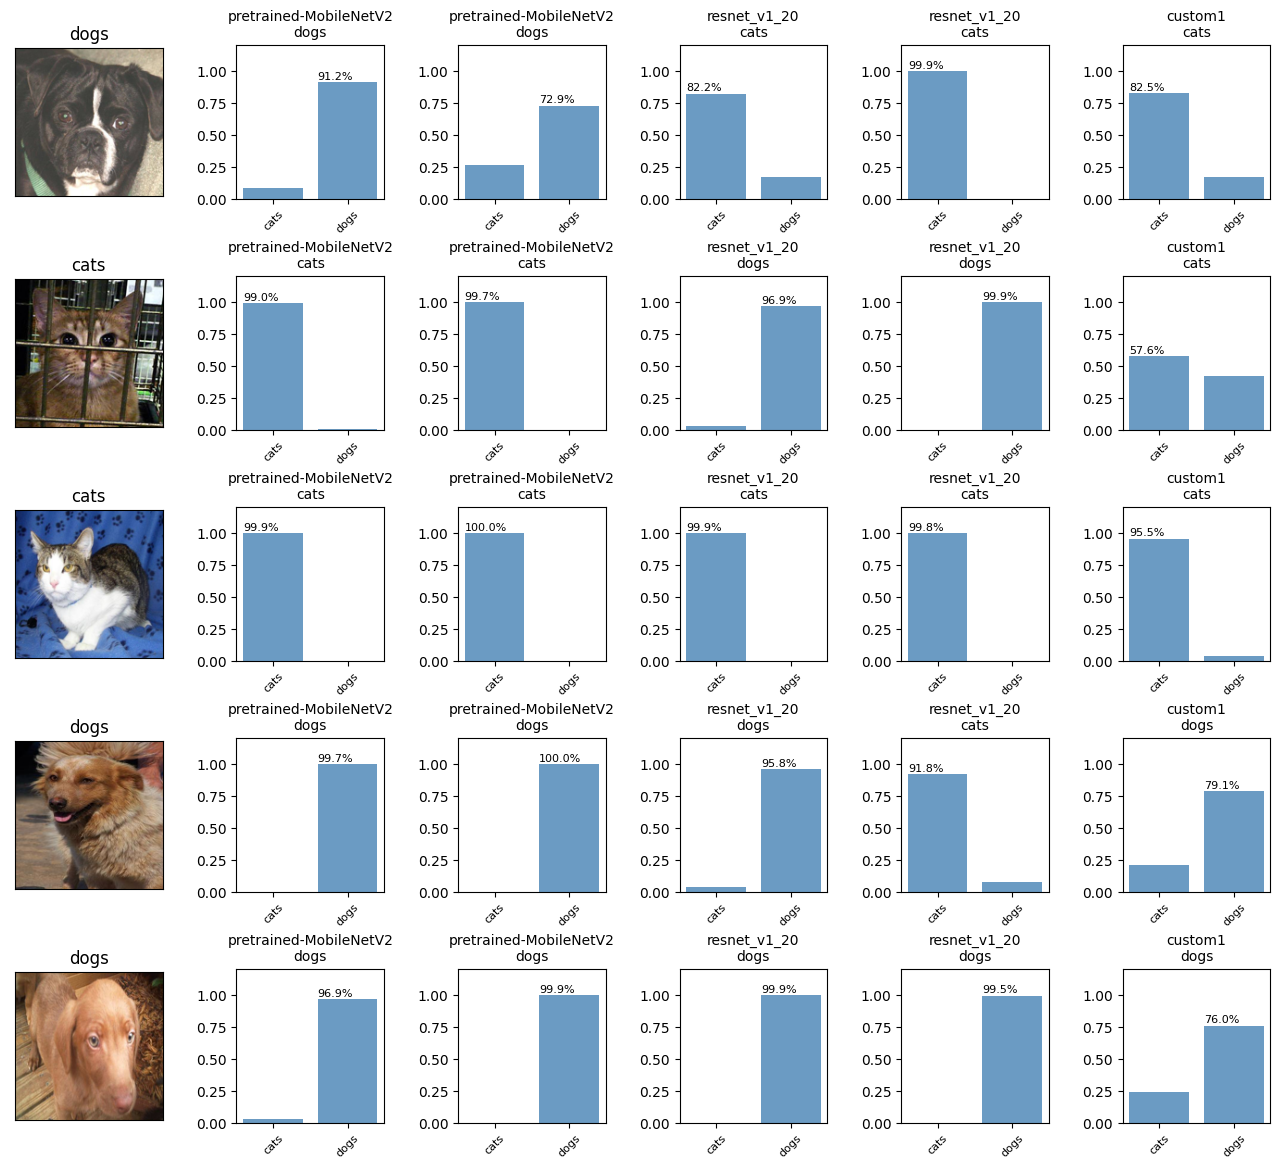

In [43]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 10ms/step


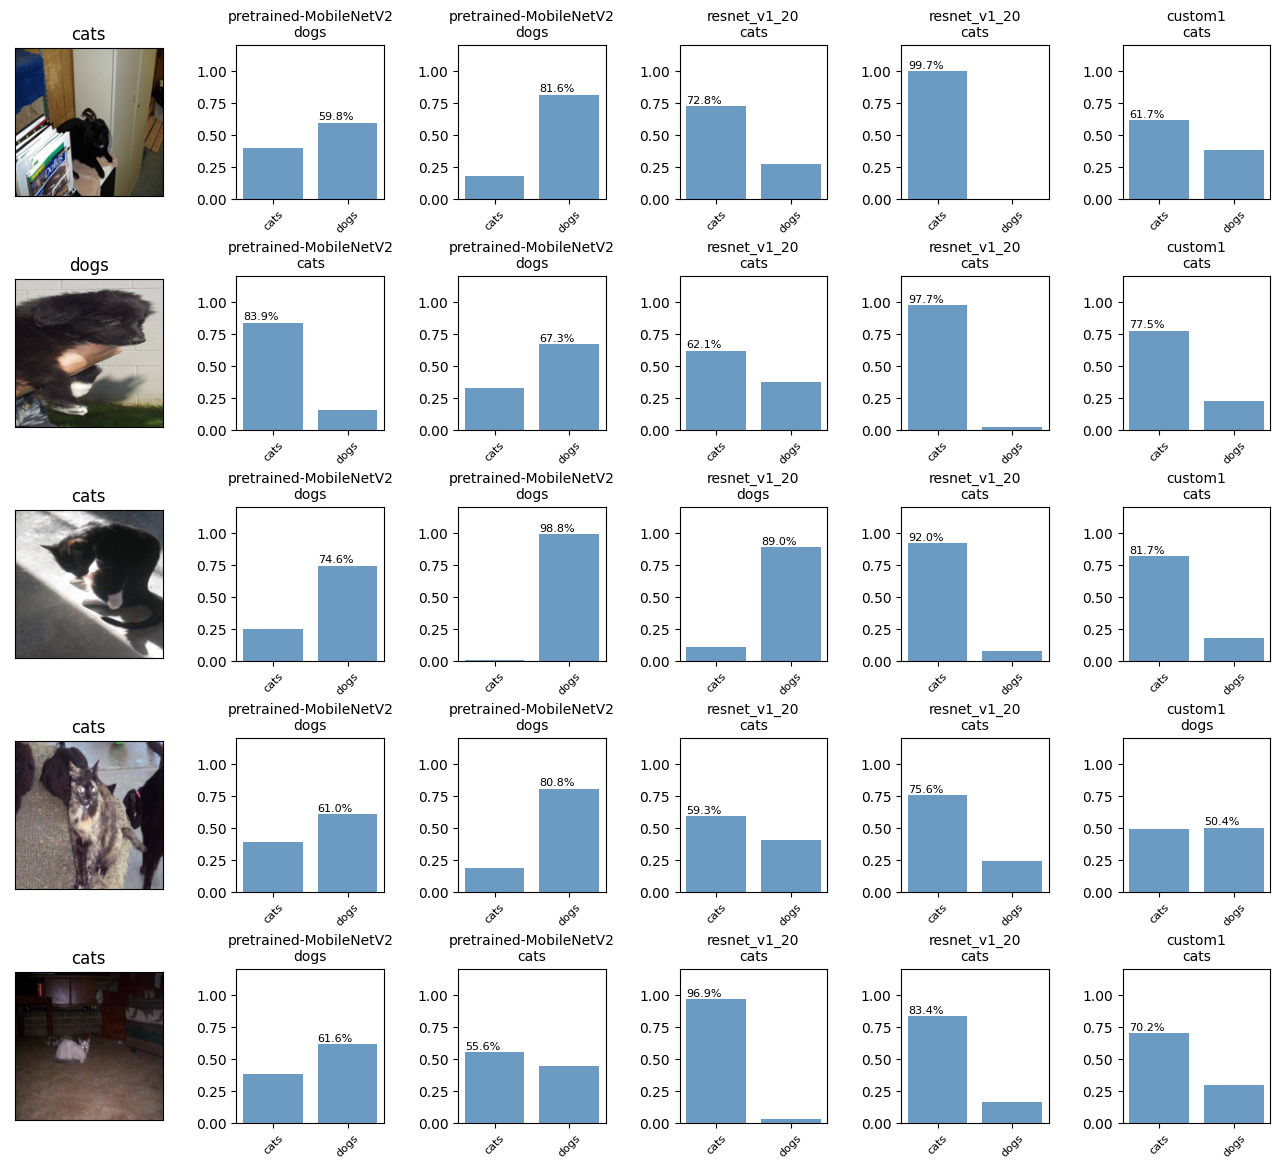

In [44]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### Evaluate

In [45]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.052060939371585846, 'accuracy': 0.9860000014305115, 'mae': 2.655226230621338}
32/32 [==============================] - 1s 23ms/step
(1000, 2)


In [46]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

32/32 [==============================] - 1s 23ms/step


precision  recall        f1
cats   0.984064   0.988  0.986028
dogs   0.987952   0.984  0.985972

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

        cats     0.9841    0.9880    0.9860       500
        dogs     0.9880    0.9840    0.9860       500

    accuracy                         0.9860      1000
   macro avg     0.9860    0.9860    0.9860      1000
weighted avg     0.9860    0.9860    0.9860      1000



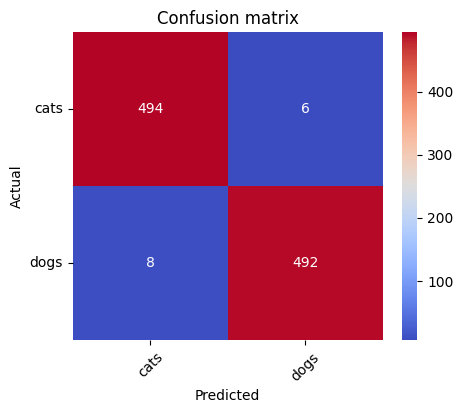

In [47]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## Reference

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)